In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

Вспомогательные функции для построения графиков и визуализации

In [3]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Сиамская нейронная сеть будет принимать в качестве входных данных два изображения для сравнения и одну метку, которая указывает, принадлежат ли изображения одному человеку.

Если изображения принадлежат одному и тому же человеку, класс вернет 0, а в противном случае вернет 1.

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        # еобходимо выбрать примерно 50% изображений, принадлежащих одному классу
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                # ищем, пока не будет найдено изображение того же класса
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                # ищем, пока не будет найдено изображение другого класса
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
# Загрузить обучающий набор данных
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

# Изменить размер изображений и преобразовать их в тензоры
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

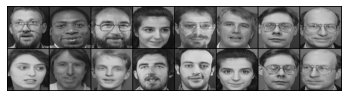

[1. 1. 1. 1. 1. 1. 0. 0.]


In [6]:
# создадим загрузчик данных для визуализации результатов
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=5) # размер батча = количество пар изображений на выходе

# извлекаем один батч
example_batch = next(iter(vis_dataloader))
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

# Обучение модели
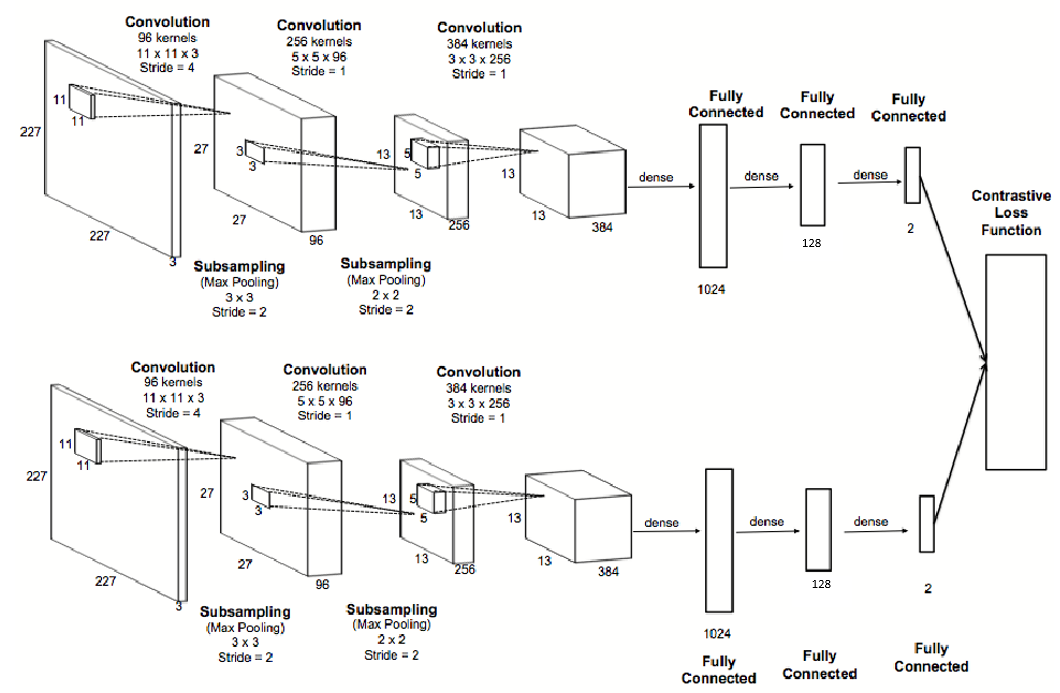

Рассмотрим подробнее архитектуру сиамской нейронной сети.

В основе лежит две идентичные нейронные сети, которые принимают на вход два различных изображения для сравнения. 

In [7]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # два последовательныз слоя: сверточный и полносвязный (Fully Connected)
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4), # одномерный входной сигнал - изображение в градациях серого
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2), # размер ядра и шаг установлены в соответствии с картинкой
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # функция вызывается для обоих изображений
        # выходные данные функции используются для определения сходства
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

![Формула функции контрастных потерь]("C:\Users\Sveta\Downloads\загрузка.png")

In [8]:
# Класс для расчета функции потерь (Contrastive Loss Function)
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # вычислить евклидово расстояние и рассчитать контрастные потери
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [9]:
# загружаем тренировочный датасет
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Обучение

Epoch number 0
 Current loss 2.2461297512054443

Epoch number 1
 Current loss 0.6783288717269897

Epoch number 2
 Current loss 0.3917838931083679

Epoch number 3
 Current loss 0.5995226502418518

Epoch number 4
 Current loss 0.7069153189659119

Epoch number 5
 Current loss 1.432775616645813

Epoch number 6
 Current loss 0.8786637783050537

Epoch number 7
 Current loss 0.5259854197502136

Epoch number 8
 Current loss 0.6351839303970337

Epoch number 9
 Current loss 0.8029335141181946

Epoch number 10
 Current loss 0.7756023406982422

Epoch number 11
 Current loss 0.9910614490509033

Epoch number 12
 Current loss 0.6698022484779358

Epoch number 13
 Current loss 0.5989584922790527

Epoch number 14
 Current loss 0.52255779504776

Epoch number 15
 Current loss 0.7778866291046143

Epoch number 16
 Current loss 0.40371766686439514

Epoch number 17
 Current loss 0.549454391002655

Epoch number 18
 Current loss 0.5635272860527039

Epoch number 19
 Current loss 0.5667874813079834

Epoch number 

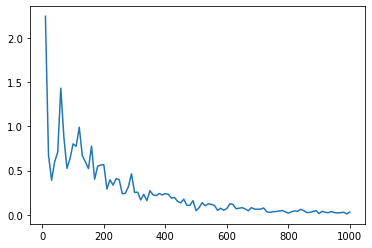

In [10]:
counter = [] #заводим счетчик для дальнейшей визуализации
loss_history = [] 
iteration_number= 0

for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        # обнуление градиента
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        # Передать выходные данные сетей и метки в функцию потерь
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()

        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

# Тестирование

Мы передаем два изображения в модель и получаем два вектора, которые затем передаются в функцию для вычисления евклидова расстояния между этими векторами. 

Эта метрика используется в качестве показателя того, насколько непохожи эти два лица

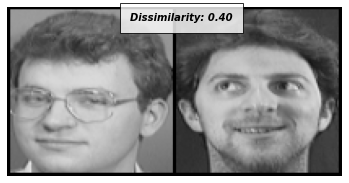

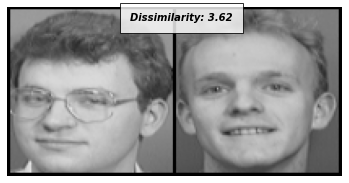

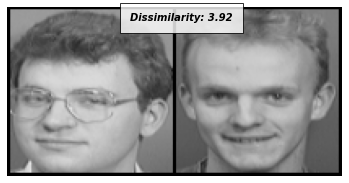

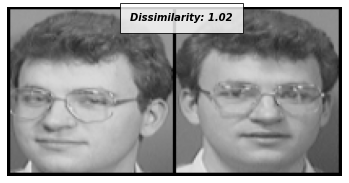

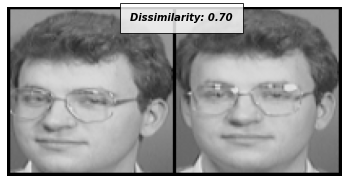

In [11]:
# загружаем тестовый набор данных 
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# выбрать одно изображение для тестирование
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    _, x1, label2 = next(dataiter)

    # Объединить два изображения вместе
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2) # считаем евклидово расстояние, а не контрастную функцию потерь!!!
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')